In [5]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score,mean_absolute_error,classification_report
from keras import Model
from tensorflow.keras.layers import Input,Activation,Add, MaxPooling2D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow import keras
from tensorflow.keras import layers, models
from skimage import color
from skimage import filters
import tensorflow as tf
from tensorflow.keras.regularizers import L1L2
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, LeakyReLU


# Model to examine
model = tf.keras.models.load_model('CNNmodelgreysobel10000dp04.h5')

In [2]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 198, 198, 32)      608       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 flatten_2 (Flatten)         (None, 270848)           

In [4]:
def get_images(filelist,rgb = True, sobel = True):
    dims = 0
    if(rgb):
        dims+=3
    else:
        dims+=1
    if(sobel):
        dims+=1
    container = np.zeros((len(filelist),200,200,dims))
    if(rgb): 
        for index,i in enumerate(filelist):
            img = cv2.imread(i)
            container[index,:,:,:3]=img
            if(sobel):
                grayImg = color.rgb2gray(img)
                edge_sobel = filters.sobel(grayImg)
                container[index,:,:,3]=edge_sobel
    else:
        for index,i in enumerate(filelist):
            img = cv2.imread(i)
            grayImg = color.rgb2gray(img)
            container[index,:,:,0]=grayImg
            if(sobel):
                edge_sobel = filters.sobel(grayImg)
                container[index,:,:,1]=edge_sobel
    return container

In [32]:
imagecontainer = get_images(['../data/raw/CroppedImages/35_0_3_20170104215607486.jpg.chip.jpg'],rgb = False, sobel = True)

In [33]:
# Image to pass as input
layers_name = ['conv2d_8']

img = tf.keras.preprocessing.image.img_to_array(img)
img = imagecontainer[0]
# Get the outputs of layers we want to inspect
outputs = [
    layer.output for layer in model.layers
    if layer.name in layers_name
]

# Create a connection between the input and those target outputs
activations_model = tf.keras.models.Model(model.inputs, outputs=outputs)
activations_model.compile(optimizer='adam', loss='categorical_crossentropy')

# Get their outputs
activations_1 = activations_model.predict(np.array([img]))

1/1 [==============================] - 0s 46ms/step


In [17]:
activations_1.shape

(1, 46, 46, 128)

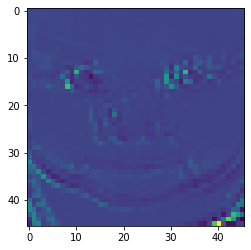

In [21]:
plt.imshow(activations_1[0,:,:,127])

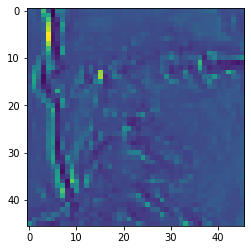

In [34]:
plt.imshow(activations_1[0,:,:,127])

In [51]:


# Layer name to inspect
layer_name = 'conv2d_8'

epochs = 100
step_size = 1.
filter_index = 1

# Create a connection between the input and the target layer
submodel = tf.keras.models.Model([model.inputs[0]], [model.get_layer(layer_name).output])

# Initiate random noise
input_img_data = np.random.random((1, 200, 200, 2))
#input_img_data = (input_img_data - 0.5) * 20 + 128.

# Cast random noise from np.float64 to tf.float32 Variable
input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

# Iterate gradient ascents
for _ in range(epochs):
    with tf.GradientTape() as tape:
        outputs = submodel(input_img_data)
        loss_value = tf.reduce_mean(outputs[:, :, :, filter_index])
    grads = tape.gradient(loss_value, input_img_data)
    normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
    input_img_data.assign_add(normalized_grads * step_size)

In [43]:
input_img_data.shape

TensorShape([1, 200, 200, 2])

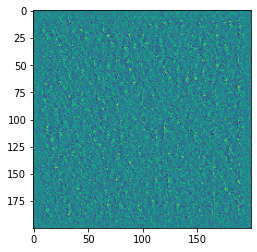

In [52]:
plt.imshow(input_img_data[0,:,:,0])

In [56]:
import numpy as np
import tensorflow as tf

# Create function to apply a grey patch on an image
def apply_grey_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = 127.5

    return patched_image



CAT_CLASS_INDEX = 0  # Imagenet tabby cat class index
PATCH_SIZE = 5

sensitivity_map = np.zeros((img.shape[0], img.shape[1]))

# Iterate the patch over the image
for top_left_x in range(0, img.shape[0], PATCH_SIZE):
    for top_left_y in range(0, img.shape[1], PATCH_SIZE):
        patched_image = apply_grey_patch(img, top_left_x, top_left_y, PATCH_SIZE)
        predicted_classes = model.predict(np.array([patched_image]),verbose=0)[0]
        confidence = predicted_classes[CAT_CLASS_INDEX]
        
        # Save confidence for this specific patched image in map
        sensitivity_map[
            top_left_y:top_left_y + PATCH_SIZE,
            top_left_x:top_left_x + PATCH_SIZE,
        ] = confidence

In [30]:
sensitivity_map.shape

(200, 200)

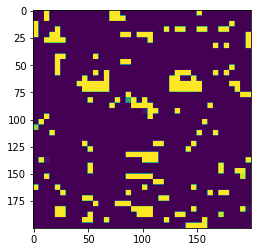

In [57]:
plt.imshow(sensitivity_map)